# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city and country code based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
# Save config information.
weatherUrl = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
weatherQueryUrl = f"{weatherUrl}appid={api_key}&units={units}&q="

## Generate Cities List
NOTE:  citipy only looks for cities with at least 500 people.  This may impact our ability to find cities near the two poles if population density is not high enough.

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
locations = pd.DataFrame()

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=5)
lngs = np.random.uniform(low=-180.000, high=180.000, size=5)
lat_lngs = zip(lats, lngs)

# Create a dataframe to store the locations
# NOTE:  Because these are randomly generated, some will not be mapped to a city
latLngs = pd.DataFrame(list(zip(lats,lngs)), columns=["Latitude", "Longitude"])

# Identify nearest city for each lat, lng combination
i = 0
for lat_lng in lat_lngs:
    result = citipy.nearest_city(lat_lng[0], lat_lng[1])
    city = result.city_name
    countryCode = result.country_code
   
    # add it to a our cities list
    locations.loc[i,"City"] = city
    locations.loc[i, "Country Code"] = countryCode

    # add in the original latitude and Longitude for comparison to the found city lat,Lon later
    locations.loc[i,"Latitude Random"] = lat_lng[0]
    locations.loc[i,"Longitude Random"] = lat_lng[1]
    i+=1
    

# Display the locations after removing duplicates
locations = locations.drop_duplicates(keep="first")
locations.head()

,City,Country Code,Latitude Random,Longitude Random
0,kailua,us,36.509240,-151.052440
1,puerto ayora,ec,0.880338,-104.321839
2,eyl,so,7.003522,49.741312
3,kapaa,us,18.837027,-179.756201
4,taolanaro,mg,-35.777336,53.163998


In [4]:
# Ensure that at least 500 unique cities were found
if len(locations) >= 500:
    print(f"Good to proceed!  {len(locations)} unique cities were identified!")
else:
    print(f"Restart!  Increase the number of random locations.  Only {len(locations)} were identified.  500 are required.")

Restart!  Increase the number of random locations.  Only 5 were identified.  500 are required.


## Latitude vs Longitude
Check for even distribution amongst the random locations

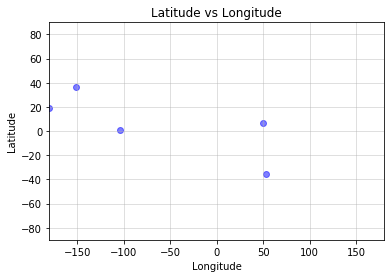

In [31]:
# Plot Latitude vs Longitude across the random data points we started with
plt.scatter(lngs, lats, c="b", alpha=0.5)
plt.title(f'Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(lng_range)
plt.ylim(lat_range)
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsLonDisbursement_RandomNoCityYet.png")
plt.show()

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
# Create a data frame for our results
weather = pd.DataFrame()
weather

""


In [7]:
# Loop through the cities and if a result is obtained, append to the weather dataframe
for index, location in locations.iterrows():
    
    # Limit of 60 calls per minute or we get locked out, so sleep between calls
    time.sleep(2)
    
    # request the weather
    response = requests.get(weatherQueryUrl + locations.loc[index]["City"] + "," + locations.loc[index]["Country Code"]).json()
    
    try:
       
    # if at least one result is found, use the first result :  assumes it will be the best match
        if (len(response)>0):
            weather.loc[index, "City"] = response["name"]
            weather.loc[index, "Cloudiness"] = response["clouds"]["all"]
            weather.loc[index, "Country"] = response["sys"]["country"]
            weather.loc[index, "Humidity"] = response["main"]["humidity"]
            weather.loc[index, "Lat"] = response["coord"]["lat"]
            weather.loc[index, "Lon"] = response["coord"]["lon"]
            weather.loc[index, "Temp"] = response["main"]["temp"]
            weather.loc[index, "Wind Speed"] = response["wind"]["speed"]
            
            # include the original lat, Lon for graphing actuals vs random later
            weather.loc[index, "Latitude Random"] = location["Latitude Random"]
            weather.loc[index, "Longitude Random"] = location["Longitude Random"]
            
            # print out the found cities
            print(f"City [{index}] = {response['name']}")
            
    except(KeyError, IndexError):
        # if we hit an exception, pring out what it was for
        print(f"Missing field/result for {locations.loc[index]['City']}, {locations.loc[index]['Country Code']}... skipping.")


City [0] = Kailua
City [1] = Puerto Ayora
City [2] = Eyl
City [3] = Kapaa
Missing field/result for taolanaro, mg... skipping.


In [8]:
# drop any rows with invalid data
weather = weather.dropna(axis=0, how='any', thresh=1, inplace=False)
weather

,City,Cloudiness,Country,Humidity,Lat,Lon,Temp,Wind Speed,Latitude Random,Longitude Random
0,Kailua,75.0,US,70.0,21.39,-157.74,28.27,3.600,36.509240,-151.052440
1,Puerto Ayora,20.0,EC,68.0,-0.74,-90.35,20.78,5.700,0.880338,-104.321839
2,Eyl,0.0,SO,86.0,7.98,49.82,26.24,3.227,7.003522,49.741312
3,Kapaa,90.0,US,88.0,22.08,-159.32,25.83,6.700,18.837027,-179.756201


In [9]:
# calculate the difference between the found city lat, lon and the original random lat, lon
weather["Lat Diff"] = weather["Latitude Random"] - weather["Lat"]
weather["Lon Diff"] = weather["Longitude Random"] - weather["Lon"]
weather

,City,Cloudiness,Country,Humidity,Lat,Lon,Temp,Wind Speed,Latitude Random,Longitude Random,Lat Diff,Lon Diff
0,Kailua,75.0,US,70.0,21.39,-157.74,28.27,3.600,36.509240,-151.052440,15.119240,6.687560
1,Puerto Ayora,20.0,EC,68.0,-0.74,-90.35,20.78,5.700,0.880338,-104.321839,1.620338,-13.971839
2,Eyl,0.0,SO,86.0,7.98,49.82,26.24,3.227,7.003522,49.741312,-0.976478,-0.078688
3,Kapaa,90.0,US,88.0,22.08,-159.32,25.83,6.700,18.837027,-179.756201,-3.242973,-20.436201


# Comparison of Random Latitude, Longitude to the matched City Lat, Lon

In [10]:
# Grab the date
tupleTime = time.localtime() # get struct_time
timeString = time.strftime("%m/%d/%Y", tupleTime)
timeString

'10/08/2019'

### First, look at the differences.
Notice that some deltas can be very large.  Therefore the citipy api has a large distance it searches for matches.

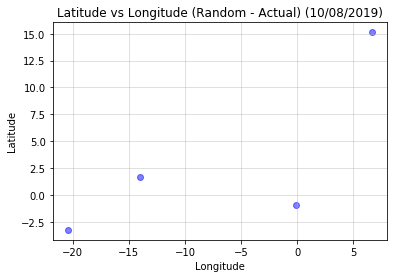

In [32]:
# Plot Latitude vs Longitude - (Random - Actual)
plt.scatter(weather["Lon Diff"], weather["Lat Diff"], c="b", alpha=0.5)
plt.title(f'Latitude vs Longitude (Random - Actual) ({timeString})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LonLat_Diff.png")
plt.show()

### Second, look at both sets of locations plotted together.
Very few cities were found near the poles and there are clearly points in the ocean and other places with no cities.

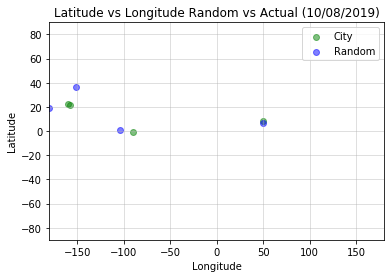

In [33]:
# Plot Latitude vs Longitude - Random vs Actual
#plt.figure(figsize=(8,8))
plt.scatter(weather["Lon"], weather["Lat"], c="g", alpha=0.5, label="City")
plt.scatter(weather["Longitude Random"], weather["Latitude Random"], c="b", alpha=0.5, label="Random")
plt.title(f'Latitude vs Longitude Random vs Actual ({timeString})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(lng_range)
plt.ylim(lat_range)
plt.legend(loc="best")
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsLon_RandomvsActual.png")
plt.show()

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [34]:
# Save the data to a csv file
weather.to_csv(path_or_buf=output_data_file, index=False)

In [35]:
# Display the dataframe length
weather.count()

City                4
Cloudiness          4
Country             4
Humidity            4
Lat                 4
Lon                 4
Temp                4
Wind Speed          4
Latitude Random     4
Longitude Random    4
Lat Diff            4
Lon Diff            4
dtype: int64

In [36]:
# Display the data frame
weather

,City,Cloudiness,Country,Humidity,Lat,Lon,Temp,Wind Speed,Latitude Random,Longitude Random,Lat Diff,Lon Diff
0,Kailua,75.0,US,70.0,21.39,-157.74,28.27,3.600,36.509240,-151.052440,15.119240,6.687560
1,Puerto Ayora,20.0,EC,68.0,-0.74,-90.35,20.78,5.700,0.880338,-104.321839,1.620338,-13.971839
2,Eyl,0.0,SO,86.0,7.98,49.82,26.24,3.227,7.003522,49.741312,-0.976478,-0.078688
3,Kapaa,90.0,US,88.0,22.08,-159.32,25.83,6.700,18.837027,-179.756201,-3.242973,-20.436201


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

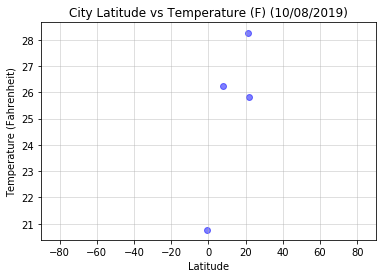

In [37]:
# Plot Latitude vs Max Temperature
plt.scatter(weather["Lat"], weather["Temp"], c="b", alpha=0.5)
plt.title(f'City Latitude vs Temperature (F) ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Temperature (Fahrenheit)')
plt.xlim(lat_range)
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsTemperature.png")
plt.show()

#### Latitude vs. Humidity Plot

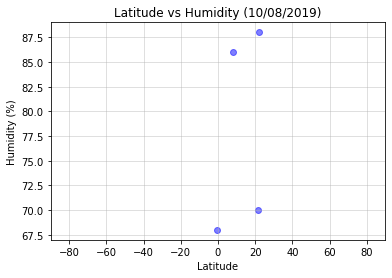

In [38]:
# Plot Latitude vs Humidity
plt.scatter(weather["Lat"], weather["Humidity"], c="b", alpha=0.5)
plt.title(f'City Latitude vs Humidity ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.xlim(lat_range)
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsHumidity.png")
plt.show()

#### Latitude vs. Cloudiness Plot

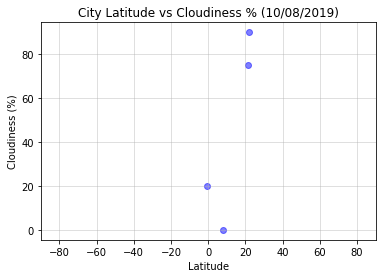

In [40]:
# Plot Latitude vs Cloudiness
plt.scatter(weather["Lat"], weather["Cloudiness"], c="b", alpha=0.5)
plt.title(f'City Latitude vs Cloudiness % ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.xlim(lat_range)
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsCloudiness.png")
plt.show()

#### Latitude vs. Wind Speed Plot

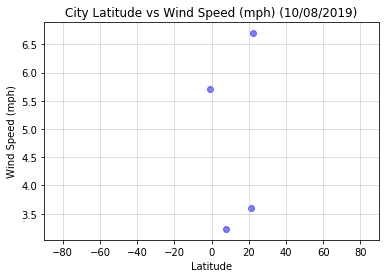

In [41]:
# Plot Latitude vs Cloudiness
plt.scatter(weather["Lat"], weather["Wind Speed"], c="b", alpha=0.5)
plt.title(f'City Latitude vs Wind Speed (mph) ({timeString})')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.xlim(lat_range)
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsWindSpeed.png")
plt.show()

## Longitude vs Latitude
Checking for relatively even distribution of resulting cities.

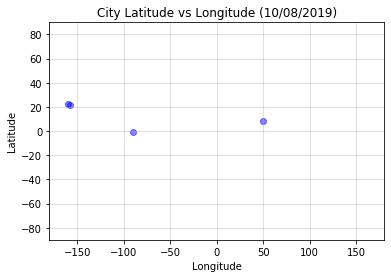

In [42]:
# Plot Latitude vs Cloudiness
plt.scatter(weather["Lon"], weather["Lat"], c="b", alpha=0.5)
plt.title(f'City Latitude vs Longitude ({timeString})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(lng_range)
plt.ylim(lat_range)
plt.grid(alpha=0.5)

# Save the image
plt.savefig("../Images/LatvsLonDisbursement_Final.png")
plt.show()

# Observations, tests and conclusions...

### citipy observations
* citipy only considers cities with at least 500 in their population.  This has a potential for eliminating cities that might be closer to the North Pole or South Pole, resuling in fewer data points at the latitude extremes.
* citipy is a limited interface that only returns city and country code, but often there is more than one city in a country with the same name, which could result in multiple responses when calling the open weather map api.
    - While I assumed the first response was the best, this could be improved upon by comparing each result to the original latitude and longitude to select the correct city.  I did not pursue this approach, however.
    
### Test:  Called Open Weather API with random locations rather than cities
* Based on multiple cities within the same country sharing a name, I tried using the latitude and longitude directly when calling the open weather map api.  I expected to get a higher percetage of successful results, but instead I received fewer.  Because our Latitude and Longitude are randomly generated they are not necessarily in an area that reports on weather.  The usage of the citipy api improves the probably of finding a result in the open weather map api.  While there is some loss in data in both approaches, the random locations had a much higher drop out rate.
* Because using random locations directly produced poor results and because it takes a long time to call citipy api, I removed that code from this jupyter notebook, but I left some of the other things I tried in here anyway.
#### Conclusion
While coverage starts out better when calling the Open Weather API, the lack of locations in weather reporting ciites results in far fewer data points.  This is a poor approach.  A better approach would be to obtain a list of all cities reporting weather through Open Weather API and randomly select their locations.

### Coverage
* Plotting original random locations vs city locations shows very few identified cities near the North and especially the South Pole.
* In an attempt to force data points near the poles I found a city near each pole and added it's location to my random locations.  However, only one of them was found in citipy.  I removed them for the purpose of completing the homework.  Here are the locations:

        Add Northernmost city > 500 Reykjavík, Iceland and Southernmost city > 500 Ushuaia, Argentina 
        lats = np.append(lats, [64.128288, -54.7999992])
        lngs = np.append(lngs, [-21.827774, -68.3000031])